In [67]:
import tensorflow as tf
import numpy as np
import os
import random
from skimage.io import imread, imshow
import skimage.transform
import matplotlib.pyplot as plt

### Prepare the Dataset

In [136]:
source_path = "S2Hand/"
label_path = "LabelHand/"

source = []
label = []
for file in os.listdir(source_path):
    if file.endswith("tif"):
      source.append(file)
        
for file in os.listdir(label_path):
    if file.endswith("tif"):
      label.append(file)

In [137]:
## SAnity Check
source = sorted(source)
label = sorted(label)
print(len(source))
print(len(label))

577
577


In [138]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 5


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

In [139]:
X = np.zeros((len(source), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(label),IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)

In [140]:
for count, file in enumerate(source):
    source_img = imread(source_path +'/' +file ) #[0:2,:,:]
    # print(f"the shape of the source image: {source_img.shape}")
    new_image = np.transpose(source_img, (1, 2, 0))
    X[count] = new_image


for count, file in enumerate(label):
    slabel_img = imread(label_path + '/'+file ) #[:,:,:,IMG_CHANNELS]
    y = np.expand_dims(slabel_img, axis=2)
    # print(f"The shape of y labels: {y.min()}")
    Y[count] = y 

In [141]:
# Sanity Check
print(X.shape)
print(Y.shape)

(577, 128, 128, 5)
(577, 128, 128, 1)


In [142]:
from sklearn.preprocessing import LabelEncoder 
labelencoder = LabelEncoder()
Y_resahped = Y.reshape(-1,1)
Y_resahped_encoded = labelencoder.fit_transform(Y_resahped)
Y_original = Y_resahped_encoded.reshape(577,128,128,1)
print(np.unique(Y_original))

[0 1 2]


### Define The UNET

In [143]:
#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(3, (1, 1), activation='softmax')(c9) #sigmoid
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name="SGD")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 128, 128, 5  0           []                               
                                )]                                                                
                                                                                                  
 lambda_9 (Lambda)              (None, 128, 128, 5)  0           ['input_10[0][0]']               
                                                                                                  
 conv2d_190 (Conv2D)            (None, 128, 128, 16  736         ['lambda_9[0][0]']               
                                )                                                                 
                                                                                           

### Train The model

In [144]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y_original, test_size=0.30)

In [145]:
from keras.utils import to_categorical
train_mask_cat = to_categorical(y_train, num_classes=3)
y_train_cat = train_mask_cat.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2],3)
print(y_train_cat.shape) # Sanity Check

(519, 128, 128, 3)


In [146]:
test_mask_cat = to_categorical(y_test, num_classes=3)
y_test_cat = test_mask_cat.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[2], 3)
print(y_test_cat.shape) # Sanity Check

(58, 128, 128, 3)


In [147]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_S2Hand.h5', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss'),checkpointer]

results = model.fit(x_train, y_train_cat, validation_split=0.1, batch_size=12, epochs=200, callbacks=callbacks)

Epoch 1/200
39/39 [==============================] - ETA: 0s - loss: 0.9790 - accuracy: 0.5462
Epoch 1: val_loss improved from inf to 0.89228, saving model to model_S2Hand.h5
39/39 [==============================] - 4s 72ms/step - loss: 0.9790 - accuracy: 0.5462 - val_loss: 0.8923 - val_accuracy: 0.6056
Epoch 2/200
39/39 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.5793
Epoch 2: val_loss improved from 0.89228 to 0.87031, saving model to model_S2Hand.h5
39/39 [==============================] - 2s 39ms/step - loss: 0.9412 - accuracy: 0.5793 - val_loss: 0.8703 - val_accuracy: 0.6068
Epoch 3/200
39/39 [==============================] - ETA: 0s - loss: 0.9368 - accuracy: 0.5804
Epoch 3: val_loss did not improve from 0.87031
39/39 [==============================] - 1s 34ms/step - loss: 0.9368 - accuracy: 0.5804 - val_loss: 0.8758 - val_accuracy: 0.6069
Epoch 4/200
39/39 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.5839
Epoch 4: val_loss i

### Evaluate the model on the test data

In [148]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test_cat, batch_size=12)
print("test loss, test acc:", results)

Evaluate on test data
5/5 [==============================] - 0s 17ms/step - loss: 0.7192 - accuracy: 0.6953
test loss, test acc: [0.7192115187644958, 0.6953198909759521]


In [149]:
# IoU
y_pred = model.predict(x_test)
y_pred_argmax = np.argmax(y_pred,  axis=3)

from keras.metrics import MeanIoU
n_classes = 3
IoU_Keras = MeanIoU(num_classes=n_classes)
IoU_Keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU: ", IoU_Keras.result().numpy())

2/2 [==============================] - 0s 30ms/step
Mean IoU:  0.4664258


### Classification Maps

1/1 [==============================] - 0s 16ms/step
(1, 128, 128)
[0 1 2]


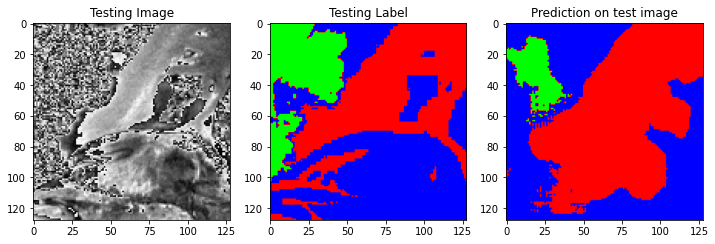

In [276]:
import random
test_img_number = 10 #10, 36
test_img = x_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img=np.argmax(prediction, axis=3)
print(predicted_img.shape)
print(np.unique(predicted_img))


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='brg')
plt.imsave('UNET_S2Hand_TestLabel.jpg', prediction_image, cmap='brg')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img[0,:,:], cmap='brg')
plt.imsave('UNET_S2Hand_Predicted.jpg', prediction_image, cmap='brg')
plt.show()